<a href="https://colab.research.google.com/github/hardiksiloiya/GANs/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
!pip install tensorflow_addons
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Activation,Concatenate,Conv2D,UpSampling2D,Dense,Flatten,Input,add
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.applications import vgg19

In [161]:
model=vgg19.VGG19(include_top=False,weights="imagenet")
feature=Model(inputs=model.input,outputs=dict([(layer.name, layer.output) for layer in model.layers]))
def content_loss(base_img,comb_img):
  #comb_img=vgg19.preprocess_input(comb_img)
  #base_img=vgg19.preprocess_input(base_img)

  #base=K.variable(base_img)
  #comb=K.variable(comb_img)
  basefeatures=feature(base_img)['block5_conv2']
  combfeatures=feature(comb_img)['block5_conv2']
  temp= K.sum(K.square(basefeatures-combfeatures))
  return temp


In [162]:
def style_loss(style_img,comb_img):
  styleloss=tf.zeros(shape=())
  #style_img=vgg19.preprocess_input(style_img)
  #comb_img=vgg19.preprocess_input(comb_img)


  s_layers=['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1','block5_conv1']
  for layer in s_layers:
    comb_feat=feature(comb_img)[layer]
    style_feat=feature(style_img)[layer]
    comb_feat=comb_feat[0]
    style_feat=style_feat[0]
    f1=K.batch_flatten(K.permute_dimensions(comb_feat,(2,0,1)))
    f2=K.batch_flatten(K.permute_dimensions(style_feat,(2,0,1)))
    g1=K.dot(f1,K.transpose(f1))
    g2=K.dot(f2,K.transpose(f2))
    styleloss=styleloss+(K.sum(K.square(g1-g2))/(4*(3**2)*(224*224)))/len(s_layers)
  return 1e-11*styleloss

In [163]:
def variance_loss(comb_img):
  a=K.square(comb_img[:,:223, :223,:]-comb_img[:,1:,:223,:])
  b=K.square(comb_img[:,:223,:223,:]-comb_img[:,:223, 1:,:])
  return K.sum(K.pow(a+b,1.25))


In [164]:
def loss(comb_img,styled_img,base_img):
  closs=2.5e-14*content_loss(base_img,comb_img)
  sloss=style_loss(styled_img,comb_img)
  vloss=1e-11*variance_loss(comb_img)
  #print('content loss - ',tf.print(closs),' style loss - ',tf.print(sloss),' variance loss - ',tf.print(vloss))
  return closs+vloss+sloss

In [165]:
def grad_and_loss(comb_img,styled_img,base_img):
  with tf.GradientTape() as tape:
    l=loss(comb_img,styled_img,base_img)
    print(l)
  grads=tape.gradient(l,comb_img)
  return l,grads

def preprocess_image(image_path):
    img=tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img=tf.keras.preprocessing.image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    img=vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    x=x.reshape((224,224, 3))
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    x=x[:,:,::-1]
    x=np.clip(x,0,255).astype("uint8")
    return x

tf.Tensor(45945.15, shape=(), dtype=float32)


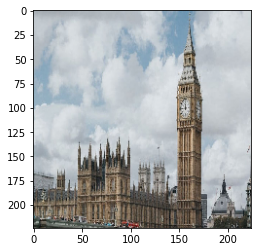

tf.Tensor(45507.176, shape=(), dtype=float32)
tf.Tensor(45058.85, shape=(), dtype=float32)
tf.Tensor(44606.137, shape=(), dtype=float32)
tf.Tensor(44148.574, shape=(), dtype=float32)
tf.Tensor(43688.617, shape=(), dtype=float32)
tf.Tensor(43229.53, shape=(), dtype=float32)
tf.Tensor(42777.41, shape=(), dtype=float32)
tf.Tensor(42333.21, shape=(), dtype=float32)
tf.Tensor(41897.113, shape=(), dtype=float32)
tf.Tensor(41472.496, shape=(), dtype=float32)
tf.Tensor(41059.08, shape=(), dtype=float32)
tf.Tensor(40654.855, shape=(), dtype=float32)
tf.Tensor(40258.543, shape=(), dtype=float32)
tf.Tensor(39870.695, shape=(), dtype=float32)
tf.Tensor(39490.58, shape=(), dtype=float32)
tf.Tensor(39116.96, shape=(), dtype=float32)
tf.Tensor(38750.16, shape=(), dtype=float32)
tf.Tensor(38388.945, shape=(), dtype=float32)
tf.Tensor(38033.727, shape=(), dtype=float32)
tf.Tensor(37685.4, shape=(), dtype=float32)
tf.Tensor(37342.652, shape=(), dtype=float32)
tf.Tensor(37004.69, shape=(), dtype=float32)

In [ ]:
optimizer=tf.keras.optimizers.SGD(1)#tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01))#,,decay_steps=100.0,decay_rate=0.56))
base_image=preprocess_image('bigben.jpg')
styled_image=preprocess_image('starry_night_full.jpg')
combination_image=tf.Variable(preprocess_image('bigben.jpg'))
#plt.imshow(base_image)
#plt.show()

'''
base_image=np.array(base_image,dtype=np.float32)
styled_image=np.array(styled_image,dtype=np.float32)
combination_image=np.array(combination_image,dtype=np.float32)
base_image=cv2.resize(base_image,dsize=(224,224),interpolation=cv2.INTER_CUBIC)
styled_image=cv2.resize(styled_image,dsize=(224,224),interpolation=cv2.INTER_CUBIC)
combination_image=cv2.resize(combination_image,dsize=(224,224),interpolation=cv2.INTER_CUBIC)
base_image=np.reshape(base_image,(1,224,224,3))
styled_image=np.reshape(styled_image,(1,224,224,3))
combination_image=tf.Variable(np.reshape(combination_image,(1,224,224,3)))
'''

iterations=4000
for i in range(iterations):
  l,g=grad_and_loss(combination_image,styled_image,base_image)
  optimizer.apply_gradients([(g,combination_image)])
  if i%100==0:
    t=deprocess_image(combination_image.numpy())
    plt.imshow(t)
    plt.show()
